In [34]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [35]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

housing.data


In [1]:
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [3]:
import numpy as np
import paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os

2021-07-10 19:47:30,814-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2021-07-10 19:47:31,157-INFO: generated new fontManager


In [4]:
BUF_SIZE = 512
BATCH_SIZE = 128

# 训练集
trainData = paddle.dataset.mnist.train()
# 测试集
testData = paddle.dataset.mnist.test()


trainReader = paddle.batch(
    paddle.reader.shuffle(
        trainData,
        buf_size = BUF_SIZE
    ), 
    batch_size = BATCH_SIZE
)


testReader = paddle.batch(
    paddle.reader.shuffle(
        testData,
        buf_size = BUF_SIZE
    ),
    batch_size = BATCH_SIZE
)

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


##网络结构

In [7]:
# 卷积
def cnn(img):
    convPool1 = fluid.nets.simple_img_conv_pool(
        # 输入图像
        input=img,
        # 卷积核大小
        filter_size=5,
        # 卷积核数目
        num_filters=20,
        # 池化层大小
        pool_size=2,
        # 池化层步长
        pool_stride=2,
        # 激活类型
        act='relu'
    )
    convPool2 = fluid.nets.simple_img_conv_pool(
        # 以第一个卷积层为输入
        input=convPool1,
        filter_size=5,
        num_filters=50,
        pool_size=2,
        pool_stride=2,
        act='relu'
    )
    convPool3 = fluid.nets.simple_img_conv_pool(
        # 以第二个卷积层为输入
        input=convPool2,
        filter_size=4,
        num_filters=20,
        pool_size=2,
        pool_stride=2,
        act='relu'
    )

    # softmax激活
    prediction = fluid.layers.fc(input=convPool3, size=10, act='softmax')

    return prediction

In [8]:
#VGG net
def conv_block(inp, numFilter, groups, dropouts):
    return fluid.nets.img_conv_group(
        input=inp,
        pool_size=2,
        pool_stride=2,
        conv_num_filter=[numFilter] * groups,
        conv_filter_size=3,
        conv_act='relu',
        conv_with_batchnorm=True,
        conv_batchnorm_drop_rate=dropouts,
        pool_type='max'
    )

def vgg(input):
    conv1 = conv_block(input, 64, 2, [0,0])
    conv2 = conv_block(conv1, 128, 2, [0,0])
    conv3 = conv_block(conv2, 128, 3, [0,0,0])
    drop = fluid.layers.dropout(x=conv3, dropout_prob=0.5)
    fc1 = fluid.layers.fc(input=drop, size=512, act=None)
    bn = fluid.layers.batch_norm(input=fc1, act='relu')
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.0)
    fc2 = fluid.layers.fc(input=drop2, size=512, act=None)

    # 全连接输出层，以softmax为激活函数，大小为10
    prediction = fluid.layers.fc(input=fc2, size=10, act='softmax')

    return prediction

In [9]:
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')
label = fluid.layers.data(name='label', shape=[1], dtype='int64')

In [10]:

model = vgg(image)


In [12]:
cost = fluid.layers.cross_entropy(input=model, label=label)
avgCost = fluid.layers.mean(cost)
# 获取准确率函数
acc = fluid.layers.accuracy(input=model, label=label)

learnRate = 0.001

myOptimizer = fluid.optimizer.SGDOptimizer(learning_rate=learnRate)

opts = myOptimizer.minimize(avgCost)

In [13]:
place = fluid.CUDAPlace(0)

exe = fluid.Executor(place)
# 参数初始化
exe.run(fluid.default_startup_program())

[]

In [14]:
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

In [15]:
allTrainIter = 0
allTrainIters = []
allTrainCosts = []
allTrainAccs = []


In [17]:
modelSavePath = 'home/aistudio/data/model'

In [18]:
# 开始训练和测试
trainTimes = 5
for timeId in range(trainTimes):
    # 训练
    for batchId, data in enumerate(trainReader()):
        trainCost, trainAcc = exe.run(
            program=fluid.default_main_program(),
            feed=feeder.feed(data),
            fetch_list=[avgCost, acc]
        )

        allTrainIter += 128
        allTrainIters.append(allTrainIter)
        allTrainCosts.append(trainCost[0])
        allTrainAccs.append(trainAcc[0])

        # 每100次batch打印一次信息
        if batchId % 100 == 0:
            print("TimeId:%d, Batch:%d, Cost:%0.5f, Acc:%0.5f" %(timeId, batchId, trainCost[0], trainAcc[0]))
    # 测试
    testAccs = []
    testCosts = []

    #每训练一轮，就测试一轮
    for batchId, data in enumerate(testReader()):
        testCost, testAcc = exe.run(
            program=fluid.default_main_program(),
            feed=feeder.feed(data),
            fetch_list=[avgCost, acc]
        )
        testAccs.append(testAcc[0])
        testCosts.append(testCost[0])

    # 求测试结果的平均值
    testCost = sum(testCosts) / len(testCosts)
    testAcc = sum(testAccs) / len(testAccs)
    print("TimeId(Test):%d, Cost:%0.5f, Acc:%0.5f" %(timeId, testCost, testAcc))


    if not os.path.exists(modelSavePath):
        os.makedirs(modelSavePath)
    print('Save Model to %s' %(modelSavePath))

    fluid.io.save_inference_model(
        modelSavePath,
        ['image'],
        [model],
        exe
    )

TimeId:0, Batch:0, Cost:0.74064, Acc:0.84375
TimeId:0, Batch:100, Cost:0.75307, Acc:0.82812
TimeId:0, Batch:200, Cost:0.65445, Acc:0.82031
TimeId:0, Batch:300, Cost:0.51393, Acc:0.89844
TimeId:0, Batch:400, Cost:0.50208, Acc:0.87500
TimeId(Test):0, Cost:0.45582, Acc:0.88845
Save Model to home/aistudio/data/model
TimeId:1, Batch:0, Cost:0.38884, Acc:0.90625
TimeId:1, Batch:100, Cost:0.54393, Acc:0.85156
TimeId:1, Batch:200, Cost:0.37394, Acc:0.91406
TimeId:1, Batch:300, Cost:0.40113, Acc:0.88281
TimeId:1, Batch:400, Cost:0.30606, Acc:0.91406
TimeId(Test):1, Cost:0.30615, Acc:0.92405
Save Model to home/aistudio/data/model
TimeId:2, Batch:0, Cost:0.24715, Acc:0.93750
TimeId:2, Batch:100, Cost:0.40177, Acc:0.91406
TimeId:2, Batch:200, Cost:0.22606, Acc:0.96094
TimeId:2, Batch:300, Cost:0.31221, Acc:0.91406
TimeId:2, Batch:400, Cost:0.15337, Acc:0.96875
TimeId(Test):2, Cost:0.23841, Acc:0.93997
Save Model to home/aistudio/data/model
TimeId:3, Batch:0, Cost:0.34502, Acc:0.90625
TimeId:3, Bat

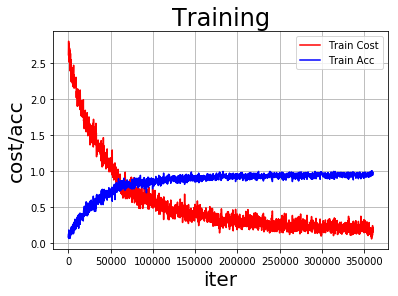

In [19]:
plt.title('Training', fontsize=24)
plt.xlabel('iter', fontsize=20)
plt.ylabel('cost/acc', fontsize=20)
plt.plot(allTrainIters, allTrainCosts, color='red', label='Train Cost')
plt.plot(allTrainIters, allTrainAccs, color='blue', label='Train Acc')
plt.legend()
plt.grid()
plt.show()


#模型测试

In [ ]:
def ImagePreprocess(path):
    img = Image.open(path).convert('L').resize((28, 28), Image.ANTIALIAS)
    img = np.array(img).reshape(1, 1, 28, 28).astype(np.float32)
    img = img / 255.0 * 2.0 - 1.0
    # print(img)

    return img